<a href="https://colab.research.google.com/github/luiztavano/Data_Finance/blob/main/Otimiza%C3%A7%C3%A3o_de_Carteiras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Estudo de otimização de carteiras de investimento



O código desenvolvido abaixo, tem por objetivo avaliar do desempenho da alocação de um conjuntos de ativos em 4 carteiras distintas, sendo elas:

* Modelo de otimização de Markowtiz (1952) minimizando o risco
* Modelo de Otimização de Markowtiz (1952) maximizando o Sharpe
* Pesos igualmente distribuídos
* Pesos aleatoriamente distribuídos

Para a composição das carterias, foi avaliado o retorno histórico de um ano dos ativos e a após o formação as carterias foram mantida por 30 dias. Esse ciclo de rebalanceamento foi repetido até o final da série histórica.

Ao final, foi gerado um gráfico com o comparativo do desempenho de cada carteria, além de uma tabela com os retornos de cada carteira ao longo do tempo.

In [ ]:
#Importação das bibliotecas
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as fig
import pandas_datareader.data as web
!pip install yfinance
import yfinance as yf
yf.pdr_override()
import scipy.optimize as solver

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def portfolio_minimo_risco(base_amostra):
    
    """
    
    Função para calcular o portfolio otimizado conforme porposto por
    Markowitz (1952) para a minimização do risco da carteira
    
    Recebe como parâmetros:
        Um dataframe com as cotações dos ativos, onde o index é a data da cotação
        e cada ativo em uma coluna diferente
        
    Retorna:
        Um Array contendo os pesos que deverão ser alocados em cada ativo
    
    """
    
    n = len(base_amostra.columns)
    
    #Calculando retorno dos ativos e covariância da carteira
    ri = base_amostra.pct_change(1)
    sigma = ri.cov()*252 #covariância da carteria
    
    #Função objetivo que minimiza o risco
    def f_obj(peso):
        return np.sqrt(np.dot(peso.T,np.dot(sigma,peso)))
    
    #Definição do chute inicial
    x0 = np.array([1.0/(n) for x in range(n)])
    
    #Definição dos limites de posição de cada ativo
    bounds = tuple((0,1) for x in range(n))
    
    #Definição das restrições
    constraints = [{'type':'eq', 'fun': lambda x: sum(x)-1}]
    
    #Executar Solver
    outcome = solver.minimize(f_obj, x0, constraints = constraints, 
                              bounds = bounds, method = 'SLSQP')
    
    pesos = outcome['x']

    return pesos

In [ ]:
def portfolio_max_sharp(base_amostra):
    
    """
    
    Função para calcular o portfolio otimizado conforme porposto por
    Markowitz (1952) para a maximação do sharpe da carteira
    
    Recebe como parâmetros:
        Um dataframe com as cotações dos ativos, onde o index é a data da cotação
        e cada ativo em uma coluna diferente
        
    Retorna:
        Um Array contendo os pesos que deverão ser alocados em cada ativo
        
    """
    
    n = len(base_amostra.columns)
    
    #Calculando retorno dos ativos e covariância da carteira
    ri = base_amostra.pct_change(1)
    rets = ri.mean()*252
    sigma = ri.cov()*252 #covariância da carteria
    
    def port_ret(peso):
        return np.sum(rets*peso)
    
    def port_vol(peso):
        return np.sqrt(np.dot(peso.T,np.dot(sigma,peso)))
        
    #Função objetivo que minimiza o risco
    def f_obj(peso):
        return -port_ret(peso)/port_vol(peso)
    
    #Definição do chute inicial
    x0 = np.array([1.0/(n) for x in range(n)])
    
    #Definição dos limites de posição de cada ativo
    bounds = tuple((0,1) for x in range(n))
    
    #Definição das restrições
    constraints = [{'type':'eq', 'fun': lambda x: sum(x)-1}]
    
    #Executar Solver
    outcome = solver.minimize(f_obj, x0, constraints = constraints, 
                              bounds = bounds, method = 'SLSQP')
    
    pesos = outcome['x']

    return pesos

In [ ]:
def avaliar_desempenho_portfolio(ri_analise, pesos, nome):
    
    """
    
    Função para realizar a avaliação do portfolio
    
    Recebe como parâmetros:
        Um dataframe com as cotações dos ativos, onde o index é a data da cotação
        e cada ativo em uma coluna diferente
        Um Array contendo os pesos que deverão ser alocados em cada ativo
        Uma String contendo o nome do portfolio avaliado
        
    Retorna:
        Retorna um dataframe contendo os retornos do portfolio avaliado durante
        o período
        
    """
    
    ri_analise_ponderada = pesos*ri_analise
    ri_analise_ponderada[nome] = ri_analise_ponderada.sum(axis = 1)
    ri_analise_ponderada = ri_analise_ponderada[[nome]]
    
    return ri_analise_ponderada

In [ ]:
def backtesting(cotacoes, data_inicio_analise, duracao_carteria,avaliacao_historico):
    
    """
    
    Função para realizar o backtesting da alocação dos portfolios abaixo:
        Portfolio com o mínimo Risco
        Portfolio máximo sharpe
        Portfolio com pesos iguais
        Portfolio com pesos alaetórios
        
    Recebe como parâmetros:
        Um dataframe com as cotações dos ativos, onde o index é a data da cotação
        e cada ativo em uma coluna diferente
        Uma data (timestamps) para o inicio da análise
        Um INT definindo quanto tempo essa carteira será mantida
        UM INT definindo um período para a avaliação do histórico
        
    Retorno:
        Retorna um dataframe contendo os retornos de cada portfolio ao longo do
        período avaliado
    
    """
    
    #Definindo Df para armazenar o resultado dos portfolios
    base_retorno = pd.DataFrame()
    
    #definindo uma data limite de avaliação
    data_limite = max(cotacoes.index)
    
    #Loop para realizar a análise ao longo do tempo
    while data_inicio_analise <= data_limite: 
        
        #Definindo data limite para a faixa de análise
        data_fim_analise = data_inicio_analise + np.timedelta64(duracao_carteria, 'D')
        
        #Definindo período de tempo para construção de carteira
        data_inicio_amostra = data_inicio_analise - np.timedelta64(avaliacao_historico, 'D')
        data_fim_amostra = data_inicio_analise - np.timedelta64(1, 'D')
        
        #Base de cotaçoes para formação da carteira
        base_amostra = cotacoes[data_inicio_amostra:data_fim_amostra]
        
        #Calculando carteira que minimiza o riscos    
        pesos_minimo_risco = portfolio_minimo_risco(base_amostra)
        
        #Calculando carteira que maximiza o sharpe    
        pesos_maximo_sharpe = portfolio_max_sharp(base_amostra)
        
        n = len(cotacoes.columns)
        
        #Calculando carteira com pesos iguais
        pesos_iguais = np.array([1.0/(n) for x in range(n)])
        
        #Gerar pesos aletatórios
        pesos_aleatorios = np.random.random(n)
        pesos_aleatorios = pesos_aleatorios/np.sum(pesos_aleatorios)
        
        #Base de cotações para análise do desempenho da carteira           
        base_analise = cotacoes[data_inicio_analise:data_fim_analise]
        
        #Calcular retornos base de cotações para análise
        ri_analise = base_analise.pct_change(1)
        ri_analise = ri_analise.dropna()
        
        #função para avaliar o desempenho do portofolio
        desempenho_portfolio_min_risco = avaliar_desempenho_portfolio(ri_analise, pesos_minimo_risco,"Portfolio minimo risco")
        
        #Criar base para armazenar os vários retornos de portfolios
        retornos = desempenho_portfolio_min_risco
        
        #função para avaliar o desempenho do portofolio
        desempenho_portfolio_max_sharpe = avaliar_desempenho_portfolio(ri_analise, pesos_maximo_sharpe,"Portfolio maximo sharpe")
        
        #Adicionar o desempenho do portfólio com pesos iguais a base de retorno
        retornos = retornos.merge(desempenho_portfolio_max_sharpe, how = 'left', on = 'Date')
        
        #função para avaliar o desempenho do portofolio
        desempenho_portfolio_pesos_iguais = avaliar_desempenho_portfolio(ri_analise, pesos_iguais,"Portfolio pesos iguais")
        
        #Adicionar o desempenho do portfólio com pesos iguais a base de retorno
        retornos = retornos.merge(desempenho_portfolio_pesos_iguais, how = 'left', on = 'Date')
        
        #função para avaliar o desempenho do portofolio
        desempenho_portfolio_pesos_aleatorios = avaliar_desempenho_portfolio(ri_analise, pesos_aleatorios,"Portfolio pesos aleatorios")
        
        #Adicionar o desempenho do portfólio com pesos iguais a base de retorno
        retornos = retornos.merge(desempenho_portfolio_pesos_aleatorios, how = 'left', on = 'Date')
                
        #Substituir a data do início da análise
        data_inicio_analise = data_fim_analise
        
        #Adicionar retornos obtidos na base de retorno de todos os períodos avaliados
        base_retorno = base_retorno.append(retornos)
    
    #Calcular retorno médio e risco
    mi = base_retorno.mean()
    sigma = base_retorno.std()
    sharpe = mi/sigma
    print("Resultado backtesting")
    print("\n---> Retorno")
    print(mi)
    print("\n---> Risco")
    print(sigma)
    print("\n---> Sharpe")
    print(sharpe)

    #Calcular retornos acumulados
    base_retorno_acumulado = base_retorno.cumsum()
    base_retorno_acumulado.plot()
    
    return base_retorno

[*********************100%***********************]  8 of 8 completed
Resultado backtesting

---> Retorno
Portfolio minimo risco        0.000637
Portfolio maximo sharpe       0.000964
Portfolio pesos iguais        0.000640
Portfolio pesos aleatorios    0.000440
dtype: float64

---> Risco
Portfolio minimo risco        0.014681
Portfolio maximo sharpe       0.014470
Portfolio pesos iguais        0.020818
Portfolio pesos aleatorios    0.022031
dtype: float64

---> Sharpe
Portfolio minimo risco        0.043401
Portfolio maximo sharpe       0.066649
Portfolio pesos iguais        0.030744
Portfolio pesos aleatorios    0.019974
dtype: float64


,Portfolio minimo risco,Portfolio maximo sharpe,Portfolio pesos iguais,Portfolio pesos aleatorios
Date,,,,
2019-01-03,-0.002816,-0.007895,0.011761,0.001968
2019-01-04,0.026667,0.036659,0.003205,0.010322
2019-01-07,-0.007320,-0.009222,-0.002669,-0.001667
2019-01-08,0.003844,-0.000218,0.006245,0.002912
2019-01-09,0.006382,0.007900,0.010169,0.010658
...,...,...,...,...
2021-12-23,-0.004173,0.013342,0.002310,0.003590
2021-12-27,0.001379,0.003983,0.005978,0.006489
2021-12-28,-0.005832,0.001378,-0.004082,-0.005530


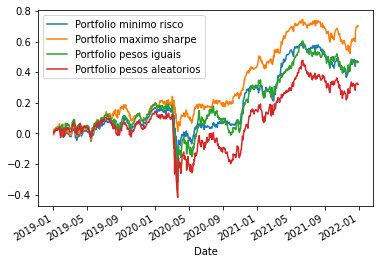

In [ ]:
#Ações avaliadas
tickers = ["PETR4.SA","VALE3.SA", "BBAS3.SA", "BBDC4.SA", "ITUB4.SA",
           "ELET6.SA", "EMBR3.SA", "TAEE11.SA"]

#Obtendo cotações
cotacoes = web.get_data_yahoo(tickers, start = "2017-01-01", end = "2021-12-31")["Adj Close"]
cotacoes = cotacoes.fillna(method = 'ffill')

#Definindo data do início de análise
data_inicio_analise = pd.to_datetime("2019-01-01")

#Duração da carteira em dias
duracao_carteria = 30

#Histório de avaliaçaõ em dias
avaliacao_historico = 365

#Chamar função para realizar backtesting
backtesting(cotacoes, data_inicio_analise, duracao_carteria, avaliacao_historico)
